### Ted Talks Text Generator
#### Create models

Generate using a character based model.

The code is this notebook is a partial modification of several tutorials, blog posts and YouTube videos. The main sources include:
* [Text Generation With LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/) by Dr. Jason Brownlee
* [Text Generation with Python and TensorFlow/Keras](https://stackabuse.com/text-generation-with-python-and-tensorflow-keras/) by Dan Nelson
* YouTube: [167 - Text prediction using LSTM (English text)](https://youtu.be/zyCpntcVKSo?t=2) by Sreenivas B.


In [18]:
# Uncomment if running on Google Colab to view runtime information.

# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
#   print('and then re-execute this cell.')
# else:
#   print(gpu_info)

In [19]:
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#   print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
#   print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#   print('re-execute this cell.')
# else:
#   print('You are using a high-RAM runtime!')

In [20]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import random

import matplotlib.pyplot as plt 

In [21]:
# # Attach to my Google drive so I can save the csv file later
# from google.colab import drive
# drive.mount('/content/drive')

In [22]:
#tag_name = 'all_transcripts'
#tag_name = 'brain'
#tag_name = 'business'
#tag_name = 'creativity'
#tag_name = 'culture'
#tag_name = 'psychology'
#tag_name = 'science'
tag_name = 'all'

lower_corpus = False

if lower_corpus:
    corpus_file_name = tag_name + '_lowercase'
else:
    corpus_file_name = tag_name + '_sentence_case'

# This switch makes it easier running locally or in a Google Colab environment
colab = False

if colab:
    root_path = '/content/drive/MyDrive/ted/'
    data_path = f'{root_path}'
else:
    root_path = '../'
    data_path = f'{root_path}data/'
    
model_path = f'{root_path}models/'
logs_path = f'{root_path}logs/'
    
sequence_length = 40

In [23]:
# if on Google Colab, load transcripts file.
# with open(f'/content/drive/MyDrive/ted/{corpus_file_name}.txt') as f:
#   corpus = f.read()
# f.close()

# if run locally:
with open(f'{data_path}{corpus_file_name}.txt', encoding='utf-8') as f:
    corpus = f.read()
f.close()

In [24]:
corpus[0:500]

"Good morning. How are you?  Good. It's been great, hasn't it? I've been blown away by the whole thing. In fact, I'm leaving.  There have been three themes running through the conference, which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we've had and in all of the people here; just the variety of it and the range of it. The second is that it's put us in a place where we have no idea what's going to happen in te"

The code below is used in almost every article I have seen about LSTM for text generation, but this snippet is adapted from :
https://www.kaggle.com/mrisdal/intro-to-lstms-w-keras-gpu-for-text-generation/

In [25]:
all_chars = sorted(list(set(corpus)))

#remove most punctuation, but leave spaces, exclamation points, and periods
list_to_remove = ['"', '&', '-', ',', "'", '/', ';',  '—', '%','[', ']' ]
chars = [character for character in all_chars if character not in list_to_remove]
print(chars)
# hat tip to this post for the idea of removing one list from another
# https://www.geeksforgeeks.org/python-remove-all-values-from-a-list-present-in-other-list/

[' ', '!', '$', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'è', 'é', '–', '’', '“', '”', '…', '♫']


If I were to refit all of my neural network models in the future, I would add more of these unusual characters to the `list_to_remove` list to strip them out of the corpus.

In [26]:
# remove all unwanted characters from the original corpus
corpus_list = [character for character in corpus if character not in list_to_remove]

# Re-join all letters back into a single string as the updated corpus
corpus = ''.join(corpus_list)

In [27]:
print('Number of unique characters in the corpus:', len(chars))

char_indices = dict((c, i) for i, c in enumerate(chars))

indices_char = dict((i, c) for i, c in enumerate(chars))

Number of unique characters in the corpus: 75


In [28]:
# Show character to index mapping
print (char_indices)

{' ': 0, '!': 1, '$': 2, '.': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '?': 14, 'A': 15, 'B': 16, 'C': 17, 'D': 18, 'E': 19, 'F': 20, 'G': 21, 'H': 22, 'I': 23, 'J': 24, 'K': 25, 'L': 26, 'M': 27, 'N': 28, 'O': 29, 'P': 30, 'Q': 31, 'R': 32, 'S': 33, 'T': 34, 'U': 35, 'V': 36, 'W': 37, 'X': 38, 'Y': 39, 'Z': 40, 'a': 41, 'b': 42, 'c': 43, 'd': 44, 'e': 45, 'f': 46, 'g': 47, 'h': 48, 'i': 49, 'j': 50, 'k': 51, 'l': 52, 'm': 53, 'n': 54, 'o': 55, 'p': 56, 'q': 57, 'r': 58, 's': 59, 't': 60, 'u': 61, 'v': 62, 'w': 63, 'x': 64, 'y': 65, 'z': 66, 'è': 67, 'é': 68, '–': 69, '’': 70, '“': 71, '”': 72, '…': 73, '♫': 74}


In [29]:
# Show index to character mapping
print(indices_char)

{0: ' ', 1: '!', 2: '$', 3: '.', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '?', 15: 'A', 16: 'B', 17: 'C', 18: 'D', 19: 'E', 20: 'F', 21: 'G', 22: 'H', 23: 'I', 24: 'J', 25: 'K', 26: 'L', 27: 'M', 28: 'N', 29: 'O', 30: 'P', 31: 'Q', 32: 'R', 33: 'S', 34: 'T', 35: 'U', 36: 'V', 37: 'W', 38: 'X', 39: 'Y', 40: 'Z', 41: 'a', 42: 'b', 43: 'c', 44: 'd', 45: 'e', 46: 'f', 47: 'g', 48: 'h', 49: 'i', 50: 'j', 51: 'k', 52: 'l', 53: 'm', 54: 'n', 55: 'o', 56: 'p', 57: 'q', 58: 'r', 59: 's', 60: 't', 61: 'u', 62: 'v', 63: 'w', 64: 'x', 65: 'y', 66: 'z', 67: 'è', 68: 'é', 69: '–', 70: '’', 71: '“', 72: '”', 73: '…', 74: '♫'}


In [30]:
print (f'The input corpus contains {len(corpus):,} characters.')

The input corpus contains 267,106 characters.


The model will use arbitrary length of characters, e.g. 40, and then predict the next character that will appear (the 41st).

I would like to change this sequence length in different models, to see how it might affect the model's performance.

Larger might be better?

Loop through the corpus, creating segments of characters, plus a segment of a single character that would appear after it. These segments are then converted into their respective digits, and loaded into X

In addition, create a list of target values. The target, y, is a single text character, and is also converted into a corresponding numeric value.

For example, in the sentence **"Welcome to my TED talk."**, a model uses a sequence length of 8, would use the first 8 characters as its input variables, in order to predict the 9th character.

![Image](../images/welcome_1.png)

Similar to a sliding window, the next sequence of characters is moved over by one, in order to add a row for the next sample.

![Image](../images/welcome_2.png)

In [31]:
corpus[0:40]

'Good morning. How are you?  Good. Its be'

In [32]:
corpus[1:41]

'ood morning. How are you?  Good. Its bee'

In [33]:
corpus[41]

'n'

In [34]:
# For future modeling, we could try to offset the sequences by more than one
# letter. For now the model will look at every sequence right after another.
step = 1

X_numeric_list = []
y_numeric_list = []


for i in range (0, len(corpus) - sequence_length, step):
    # To find X when still as characters, loop through and extract
    # a sequence for example, from the 2nd to the 42nd, as in corpus[1:41] since 
    # the string index is zero-based
    X_char_sequence = corpus[i:i + sequence_length]  #exclusive
    y_char = corpus[i + sequence_length]

    # Convert the X character sequence into a list of integers, using the 
    # dictionary created above.
    X_numeric_list.append( [char_indices[letter] for letter in X_char_sequence])
    # Also convert target letter y to it's corresponding numeric value in the
    # dictionary
    y_numeric_list.append(char_indices[y_char])



In [35]:
# Look at the first two converted sequences
print ( X_numeric_list[0])
print ( X_numeric_list[1])


[21, 55, 55, 44, 0, 53, 55, 58, 54, 49, 54, 47, 3, 0, 22, 55, 63, 0, 41, 58, 45, 0, 65, 55, 61, 14, 0, 0, 21, 55, 55, 44, 3, 0, 23, 60, 59, 0, 42, 45]
[55, 55, 44, 0, 53, 55, 58, 54, 49, 54, 47, 3, 0, 22, 55, 63, 0, 41, 58, 45, 0, 65, 55, 61, 14, 0, 0, 21, 55, 55, 44, 3, 0, 23, 60, 59, 0, 42, 45, 45]


In [36]:
print ( y_numeric_list[0])

45


In [37]:
indices_char[45]

'e'

In [21]:
corpus[0:43]

'Good morning. How are you?  Good. Its been '

---
An example of the first record of X (in text form):<br>
`Good morning. How are you?  Good. Its be`
<br>
And its corresponding target (y) (in text form):<br>
`e`

After being converted to numeric values, the first record for X:<br>
`[21, 55, 55, 44, 0, 53, 55, 58, 54, 49, 54, 47, 3, 0, 22, 55, 63, 0, 41, 58, 45, 0, 65, 55, 61, 14, 0, 0, 21, 55, 55, 44, 3, 0, 23, 60, 59, 0, 42, 45]`

And it corresponding target (y):<br>
`45`

In [22]:
print (f'There are {len(X_numeric_list):,} entries in X_numeric_list') 

There are 267,066 entries in X_numeric_list


An LSTM model needs the X data to be in 3 dimensions:
* Samples (number of rows)
* Time steps (this implies time series. In this example this corresponds to the sequence_length)
* Features (the target, or y variable)

This [blog post by Dr. John Brownlee](https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/) contains a longer explanation, which I paraphrased here.

In [23]:
# reshape X to be [samples, time steps, features]
# Samples is the total number of 40 character text fragments created above
# Time step is the sequence length, which is this case is 40, but might change
# in other model variations
# Feature is one, since the model is predicting one character at a time
X = np.reshape(X_numeric_list, (len(X_numeric_list), sequence_length, 1))

In [24]:
X.shape

(267066, 40, 1)

In [25]:
# normalize/scale the data by dividing by the length of the character list.
X = X / len(chars)

In [26]:
# Look at the first value of X
X[0]

array([[0.28      ],
       [0.73333333],
       [0.73333333],
       [0.58666667],
       [0.        ],
       [0.70666667],
       [0.73333333],
       [0.77333333],
       [0.72      ],
       [0.65333333],
       [0.72      ],
       [0.62666667],
       [0.04      ],
       [0.        ],
       [0.29333333],
       [0.73333333],
       [0.84      ],
       [0.        ],
       [0.54666667],
       [0.77333333],
       [0.6       ],
       [0.        ],
       [0.86666667],
       [0.73333333],
       [0.81333333],
       [0.18666667],
       [0.        ],
       [0.        ],
       [0.28      ],
       [0.73333333],
       [0.73333333],
       [0.58666667],
       [0.04      ],
       [0.        ],
       [0.30666667],
       [0.8       ],
       [0.78666667],
       [0.        ],
       [0.56      ],
       [0.6       ]])

Even thought the values for the target variable are integers, they are essentially labels for the predicted characters. They are one-hot encoded using the to_categorical function.

In [27]:
y = to_categorical(y_numeric_list)
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

---
### Create LSTM Model

This [blog post](https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046) has a rule of thumb of how many nodes to include in an LSTM.

In [28]:
hidden_nodes = int(2/3 * (len(chars) * sequence_length))
print(f"The number of hidden nodes is {hidden_nodes}.")

The number of hidden nodes is 2000.


Use of ModelCheckPoint to save the model's progress example as described in the [TensorFlow documentation.](https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_options)

In [29]:
#Set a path to save the checkpoint files for this model
checkpoint_path = f'{model_path}{corpus_file_name}/{corpus_file_name}.ckpt'
checkpoint_dir = f'{model_path}{corpus_file_name}/'

# Create a callback that saves the model's weights every 50 fits
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_freq=50)

In [48]:
# # define the LSTM model
model = Sequential()
model.add(LSTM(500, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
# model.add(LSTM(16))
# model.add(Dropout(0.3))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy','Recall','Precision'])

# # Save the weights using the `checkpoint_path` format
# model.save_weights(checkpoint_path.format(epoch=0))

In [49]:
# Store this for a log file name
input_nodes_count = model.layers[0].output_shape[len(model.layers[2].output_shape)-1]
input_nodes_count

500

In [50]:
# Get the last value of shape, which contains how many nodes or output values to either the next layer, or the final Dense layer
layer_2_nodes_count=model.layers[2].output_shape[len(model.layers[2].output_shape)-1]
layer_2_nodes_count

75

In [51]:
#model = load_model(f'{root_path}/models/ted_model_{tag_name}')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 500)               1004000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 75)                37575     
Total params: 1,041,575
Trainable params: 1,041,575
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Hat tip to this stack overflow post for the CSV Logger bit:
# https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object

model_cb = ModelCheckpoint(filepath=checkpoint_path)
history_cb = CSVLogger(f'{logs_path}/{corpus_file_name}_{input_nodes_count}_{layer_2_nodes_count}_log.csv', separator=",", append=True)

In [59]:
history = model.fit(X, y, epochs=50, batch_size=100, callbacks=[model_cb, history_cb], workers=3)

Epoch 1/50
2671/2671 [==============================] - 592s 222ms/step - loss: 1.1410 - accuracy: 0.6470 - recall: 0.5200 - precision: 0.8207


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 2/50
2671/2671 [==============================] - 563s 211ms/step - loss: 1.1238 - accuracy: 0.6516 - recall: 0.5268 - precision: 0.8221


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 3/50
2671/2671 [==============================] - 577s 216ms/step - loss: 1.1121 - accuracy: 0.6550 - recall: 0.5313 - precision: 0.8213


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 4/50
2671/2671 [==============================] - 593s 222ms/step - loss: 1.0959 - accuracy: 0.6592 - recall: 0.5386 - precision: 0.8242


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 5/50
2671/2671 [==============================] - 586s 219ms/step - loss: 1.0788 - accuracy: 0.6647 - recall: 0.5451 - precision: 0.8253


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 6/50
2671/2671 [==============================] - 574s 215ms/step - loss: 1.0671 - accuracy: 0.6678 - recall: 0.5504 - precision: 0.8264


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 7/50
2671/2671 [==============================] - 591s 221ms/step - loss: 1.0478 - accuracy: 0.6733 - recall: 0.5584 - precision: 0.8277


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 8/50
2671/2671 [==============================] - 621s 233ms/step - loss: 1.0384 - accuracy: 0.6756 - recall: 0.5623 - precision: 0.8273


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 9/50
2671/2671 [==============================] - 612s 229ms/step - loss: 1.0229 - accuracy: 0.6797 - recall: 0.5676 - precision: 0.8288


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 10/50
2671/2671 [==============================] - 637s 238ms/step - loss: 1.0083 - accuracy: 0.6844 - recall: 0.5733 - precision: 0.8307


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 11/50
2671/2671 [==============================] - 600s 225ms/step - loss: 0.9922 - accuracy: 0.6892 - recall: 0.5806 - precision: 0.8315


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 12/50
2671/2671 [==============================] - 601s 225ms/step - loss: 0.9842 - accuracy: 0.6909 - recall: 0.5842 - precision: 0.8317


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 13/50
2671/2671 [==============================] - 573s 215ms/step - loss: 0.9687 - accuracy: 0.6953 - recall: 0.5897 - precision: 0.8330


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 14/50
2671/2671 [==============================] - 611s 229ms/step - loss: 0.9578 - accuracy: 0.6985 - recall: 0.5948 - precision: 0.8336


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 15/50
2671/2671 [==============================] - 622s 233ms/step - loss: 0.9466 - accuracy: 0.7005 - recall: 0.5993 - precision: 0.8338


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 16/50
2671/2671 [==============================] - 618s 231ms/step - loss: 0.9342 - accuracy: 0.7049 - recall: 0.6034 - precision: 0.8344


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 17/50
2671/2671 [==============================] - 604s 226ms/step - loss: 0.9245 - accuracy: 0.7080 - recall: 0.6086 - precision: 0.8367


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 18/50
2671/2671 [==============================] - 630s 236ms/step - loss: 0.9095 - accuracy: 0.7116 - recall: 0.6137 - precision: 0.8380


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 19/50
2671/2671 [==============================] - 665s 249ms/step - loss: 0.9022 - accuracy: 0.7135 - recall: 0.6176 - precision: 0.8364


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 20/50
2671/2671 [==============================] - 645s 241ms/step - loss: 0.8885 - accuracy: 0.7170 - recall: 0.6226 - precision: 0.8383


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 21/50
2671/2671 [==============================] - 599s 224ms/step - loss: 0.8784 - accuracy: 0.7208 - recall: 0.6283 - precision: 0.8404


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 22/50
2671/2671 [==============================] - 579s 217ms/step - loss: 0.8680 - accuracy: 0.7240 - recall: 0.6318 - precision: 0.8404


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 23/50
2671/2671 [==============================] - 620s 232ms/step - loss: 0.8590 - accuracy: 0.7259 - recall: 0.6348 - precision: 0.8415


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 24/50
2671/2671 [==============================] - 606s 227ms/step - loss: 0.8490 - accuracy: 0.7292 - recall: 0.6404 - precision: 0.8421


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 25/50
2671/2671 [==============================] - 606s 227ms/step - loss: 0.8388 - accuracy: 0.7322 - recall: 0.6436 - precision: 0.8432


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 26/50
2671/2671 [==============================] - 591s 221ms/step - loss: 0.8302 - accuracy: 0.7349 - recall: 0.6481 - precision: 0.8441


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 27/50
2671/2671 [==============================] - 591s 221ms/step - loss: 0.8241 - accuracy: 0.7369 - recall: 0.6506 - precision: 0.8452


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 28/50
2671/2671 [==============================] - 584s 219ms/step - loss: 0.8151 - accuracy: 0.7390 - recall: 0.6539 - precision: 0.8446


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 29/50
2671/2671 [==============================] - 601s 225ms/step - loss: 0.8066 - accuracy: 0.7412 - recall: 0.6571 - precision: 0.8470


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 30/50
2671/2671 [==============================] - 600s 225ms/step - loss: 0.7965 - accuracy: 0.7440 - recall: 0.6619 - precision: 0.8471


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 31/50
2671/2671 [==============================] - 605s 227ms/step - loss: 0.7882 - accuracy: 0.7474 - recall: 0.6658 - precision: 0.8482


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 32/50
2671/2671 [==============================] - 585s 219ms/step - loss: 0.7804 - accuracy: 0.7487 - recall: 0.6685 - precision: 0.8483


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 33/50
2671/2671 [==============================] - 610s 229ms/step - loss: 0.7739 - accuracy: 0.7517 - recall: 0.6725 - precision: 0.8495


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 34/50
2671/2671 [==============================] - 579s 217ms/step - loss: 0.7692 - accuracy: 0.7519 - recall: 0.6740 - precision: 0.8496


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 35/50
2671/2671 [==============================] - 554s 207ms/step - loss: 0.7588 - accuracy: 0.7556 - recall: 0.6777 - precision: 0.8509


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 36/50
2671/2671 [==============================] - 550s 206ms/step - loss: 0.7535 - accuracy: 0.7573 - recall: 0.6809 - precision: 0.8513


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 37/50
2671/2671 [==============================] - 517s 194ms/step - loss: 0.7414 - accuracy: 0.7604 - recall: 0.6858 - precision: 0.8536


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 38/50
2671/2671 [==============================] - 506s 189ms/step - loss: 0.7356 - accuracy: 0.7616 - recall: 0.6876 - precision: 0.8519


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 39/50
2671/2671 [==============================] - 493s 185ms/step - loss: 0.7296 - accuracy: 0.7643 - recall: 0.6902 - precision: 0.8541


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 40/50
2671/2671 [==============================] - 507s 190ms/step - loss: 0.7246 - accuracy: 0.7654 - recall: 0.6927 - precision: 0.8540s - loss: 0.7237 - accuracy: 0.765


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 41/50
2671/2671 [==============================] - 499s 187ms/step - loss: 0.7145 - accuracy: 0.7690 - recall: 0.6971 - precision: 0.8561


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 42/50
2671/2671 [==============================] - 498s 186ms/step - loss: 0.7098 - accuracy: 0.7696 - recall: 0.6993 - precision: 0.8559


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 43/50
2671/2671 [==============================] - 495s 185ms/step - loss: 0.7001 - accuracy: 0.7731 - recall: 0.7036 - precision: 0.8573s - loss: 0.6998 - accuracy: 0.7732 - recall: 0.7037 - preci


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 44/50
2671/2671 [==============================] - 489s 183ms/step - loss: 0.6990 - accuracy: 0.7735 - recall: 0.7040 - precision: 0.8567


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 45/50
2671/2671 [==============================] - 484s 181ms/step - loss: 0.6935 - accuracy: 0.7748 - recall: 0.7068 - precision: 0.8570


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 46/50
2671/2671 [==============================] - 477s 178ms/step - loss: 0.6827 - accuracy: 0.7785 - recall: 0.7106 - precision: 0.8593


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 47/50
2671/2671 [==============================] - 472s 177ms/step - loss: 0.6835 - accuracy: 0.7778 - recall: 0.7105 - precision: 0.8580


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 48/50
2671/2671 [==============================] - 482s 180ms/step - loss: 0.6748 - accuracy: 0.7807 - recall: 0.7140 - precision: 0.8593s - loss: 0.6748 - accuracy: 0.7807 - recall: 0.7140 - preci


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 49/50
2671/2671 [==============================] - 493s 184ms/step - loss: 0.6709 - accuracy: 0.7814 - recall: 0.7167 - precision: 0.8591


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


Epoch 50/50
2671/2671 [==============================] - 477s 179ms/step - loss: 0.6671 - accuracy: 0.7823 - recall: 0.7180 - precision: 0.8593


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


INFO:tensorflow:Assets written to: ../models/all_sentence_case\all_sentence_case.ckpt\assets


In [60]:
# Save the model to my Google Drive so I can load it later from another notebook
#model.save(f'/content/drive/MyDrive/ted/models/ted_model_{tag_name}')

print(f'Saving model:{model_path}{tag_name}_{input_nodes_count}_{layer_2_nodes_count}')
model.save(f'{model_path}{tag_name}_{input_nodes_count}_{layer_2_nodes_count}')

Saving model:../models/all_500_75


INFO:tensorflow:Assets written to: ../models/all_500_75\assets


INFO:tensorflow:Assets written to: ../models/all_500_75\assets


dict_keys(['loss', 'accuracy', 'recall', 'precision'])


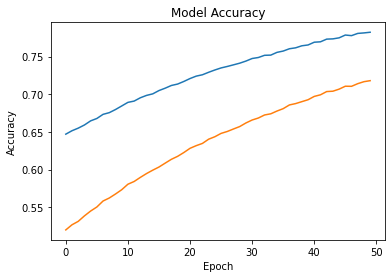

In [61]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['recall'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend( loc='upper left')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()